In [181]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from numpy import log,exp

DELTA = 0.9

#Normalize logarithmic probabilities
#Return regular probabilities
def normalize(w):
    return( exp(w-w.max()) )

#Hamming distance between two sequences
def hamming(s1, s2):
    d = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            d += 1
    return d

#freq: pairwise frequences. Marginal probabilities are included on diagonal 4d np.array [site1, site2, allele1, allele2]
#seqs: sequences encoded with numbers, 2D np.array [sequence, allele]
#delta: "decorrelation" power
#seed: random seed
#verbose: verbose mode for debugging (can produce a lot of output!)
#keep_states: write all the visited states (sequences) in a list
#keep_weights: write all the proposal weights in a list

class DCA:
    def __init__(self, freq, seqs, delta = DELTA, seed=24122022, verbose = False, keep_states = False, keep_weights=False):
        rnd.seed(seed)
        self.PP = freq
        self.s = seqs
        self.delta = delta
        self.L = len(seqs[0])
        self.M = len(seqs)
        self.A = ALPHABET_SIZE
        #self.P = np.zeros((selfL, A, A))
        self.P = self.PP.sum(axis=1)
        
        self.currentDist = 0
        self.H = np.ones(self.L+1, dtype=int)
        
        self.verbose = verbose
        self.keep_states = keep_states
        self.keep_weights = keep_weights
        if self.keep_states:
            self.states = []
        if self.keep_weights:
            self.weights = []

    #Calculate transition weights for the sequence seq at position pos
    def calc_w(self, seq, pos):
        weights = np.ones(self.A)
        for a in range(self.A):
            for pos_i in range(self.L):
                if pos_i == pos:
                    weights[a] += log(self.PP[pos, pos, a, a])
                else:
                    weights[a] += log(self.PP[pos, pos_i, a, seq[pos_i]])
            weights[a] = weights[a]*self.delta
        weights = normalize(weights)
        return(weights)
                
    #One iteration step
    def step(self):
        if self.verbose:
            print("STEP")
            print(self.currentState, self.currentDist)
        pos = rnd.choice(self.L)
        weights = self.calc_w(self.currentState, pos)
        if self.verbose:
            print("weights = ", weights)
        new_a = rnd.choice(self.A, p=weights/weights.sum())
        if self.verbose:
            print("pos = ", pos, " new_a = ", new_a)
        if new_a == self.currentState[pos] or (self.currentState[pos] != self.s[ self.initSeq,  pos] and new_a != self.s[ self.initSeq,  pos]):
            newDist = self.currentDist
        elif new_a == self.s[ self.initSeq, pos ]:
            newDist = self.currentDist - 1
        else:
            newDist = self.currentDist + 1
        p = self.H[self.currentDist]/self.H[newDist]
        if p >= 1. or rnd.choice(2, p=[1.-p, p]) == 1:
            self.currentState[pos] = new_a
            self.currentDist = newDist
        self.H[self.currentDist] += 1
        if self.keep_states:
            self.states.append( np.copy(self.currentState) )
        if self.keep_weights:
            self.weights.append(weights)
        
    #Run random walk on sequences and H_k
    def run(self, iterations, sid):
        self.initSeq = sid
        self.currentState = np.copy(self.s[ self.initSeq ])
        if self.keep_states:
            self.states.append( np.copy(self.currentState) )
        for i in range(iterations):
            self.step()
            
#dca = DCA(freq, seqs, keep_states=True, verbose = False)
#dca.run(100)

#print(dca.H)

#plt.plot(dca.H/sum(dca.H))

In [75]:
#Toy example for debugging
ALPHABET_SIZE = 2

def ReadFreq(fn):
    return data

def ReadSeqs(fn):
    return data

freq = np.array([
    [
    #0,0
    [ [0.1, 0.], [0., 0.0] ],
    #0,1
    [ [0.1, 0.2], [0.3, 0.4] ],
    #0,2
    [ [0.05, 0.15], [0.25, 0.55] ]
    ],
    [
    #1,0
    [ [0.1, 0.3], [0.2, 0.4] ],
    #1,1
    [ [0.2, 0.], [0., 0.8] ],
    #1,2
    [ [0.1, 0.3], [0.2, 0.4] ]
    ],
    [
    #2,0
    [ [0.05, 0.25], [0.15, 0.55] ],
    #2,1
    [ [0.1, 0.2], [0.3, 0.4] ],
    #2,2
    [ [0.3, 0.], [0., 0.7] ]
    ]

])
seqs = np.array([ [0, 1, 0] ])

array([4, 0, 3, 0, 3, 1, 1, 1, 1, 2, 1, 3, 4, 2, 0, 4, 2, 1, 3, 4, 4, 1,
       1, 1, 0, 3, 4, 1, 3, 4, 2, 0, 3, 1, 3, 0, 2, 1, 0, 4, 2, 0, 0, 3,
       4, 3, 0, 4, 0, 2, 1, 3, 4, 3, 0, 0, 4, 2, 1, 2, 4, 0, 4, 3, 1, 3,
       3, 0, 1, 0, 2, 3, 1, 4, 1, 0, 3, 1, 3, 4, 0, 2, 2, 1, 2, 2, 4, 2,
       4, 1, 4, 3, 3, 0, 2, 3, 4, 4, 0, 4])

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20}
Number of sequences:  62


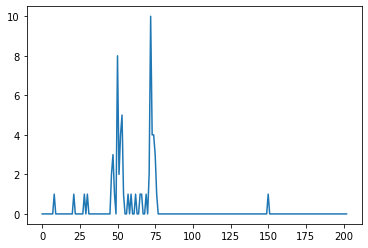

In [143]:
#Real data

#Amino acids
ALPHABET="ARNDCQEGHILKMFPSTWYV-"
ALPHABET_SIZE = len(ALPHABET)
L2N = {ALPHABET[i]: i for i in range(ALPHABET_SIZE)}#letter to number dictionary for reencoding sequences with numbers

#Read fasta file (need update - see #FIXME line)
fn="01_sars2_rbd.stat/RBDs_aa_aligned_v3.fasta"
seqs = []
with open(fn) as f:
    for l in f:
        l = l.rstrip()
        if l[0] == ">":
            name = l[1:]
            s = ""
        elif len(l) > 30:#FIXME
            s = s+l
        else:
            s = s+l
            s = s.replace("X", "-")
            s = [L2N[symbol] for symbol in s]
            seqs.append([name, s])
M = len(seqs)
L = len(seqs[0][1])
print("Number of sequences:", M)
print("Sequence length:", L)

#Calculate and plot Hamming distances from sequence sid to the rest of the dataset
sid = 0
G = np.zeros(L, dtype = "int")
for i in range(len(seqs)):
    if i == sid:
        continue
    n = hamming(seqs[sid][1], seqs[i][1])
    G[n] += 1
    
plt.plot(G)
    

In [62]:
#Real data
#Read pairwise frequences
fn="01_sars2_rbd.stat/RBDs_aa_aligned_v3/RBDs_aa_aligned_v3.fij_ab"

freq = np.zeros((L,L,ALPHABET_SIZE,ALPHABET_SIZE))

print("seq len = ", L)

with open(fn) as f:
    for l in f:
        if l[0:4]=="site":
            l = l.rstrip()
            l = l.split("\t")
            continue
        l = l.rstrip()
        if l == '':
            continue
        lll = l.split("\t")
        site1, site2 = int(lll[0])-1, int(lll[1])-1
        #fr = np.array( [float(x) for x in lll[2:2+ALPHABET_SIZE*ALPHABET_SIZE]] )
        fr = np.array( [float(x) for x in lll[2:]] )
        if len(fr) != 441:
            print(site1+1, site2+1)
            print(l.replace("\t", "@"))
        fr = np.reshape(fr, (ALPHABET_SIZE,ALPHABET_SIZE) )

            
        freq[site1, site2, ] = fr
        freq[site2, site1, ] = fr


seq len =  203


In [63]:
#Real data
#Read marginal frequences
fn="01_sars2_rbd.stat/RBDs_aa_aligned_v3/RBDs_aa_aligned_v3.fi_a"
print("seq len = ", L)

with open(fn) as f:
    for l in f:
        if l[0:4]=="site":
            continue
        l = l.rstrip()
        if l == '':
            continue
        lll = l.split("\t")
        site1 = int(lll[0])-1
        #fr = np.array( [float(x) for x in lll[1:1+ALPHABET_SIZE]] )
        fr = np.array( [float(x) for x in lll[1:]] )
        for i in range(ALPHABET_SIZE):
            freq[site1, site1, i, i] = fr[i]

seq len =  203


In [183]:
#Run DCA class from sequence sid
iterations = 10000
sid = 0
dca = DCA(freq, np.array([el[1] for el in seqs]), delta = 0.05, keep_states=True)
dca.run(iterations, sid)

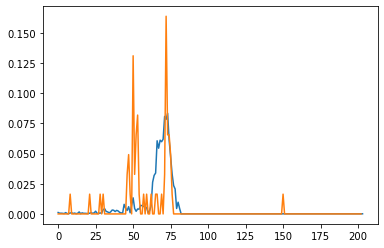

In [184]:
#Plot normalized H and empirical G (see cell above)

plt.plot(dca.H/sum(dca.H))
plt.plot(G/sum(G))

In [188]:
#Writes sequences seqs to the file fn
#CAREFUL: This function appends data if the file fn exists
def write_fasta(fn, seqs):
    f = open(fn, "a")
    for i in range(len(seqs)):
        f.write(">"+str(i)+"\n")
        s = [ALPHABET[el] for el in seqs[i]]
        f.write( "".join(s) )
        f.write("\n")
    f.close()
        
fn = "output.fasta"
write_fasta(fn, dca.states)

In [187]:
#Ignore
for j in range(len(dca.s)):
    Gs = np.zeros(L, dtype = "int")
    for i in range(len(dca.states)):
        if i == sid:
            continue
        n = hamming(dca.s[j], dca.states[i])
        Gs[n] += 1
    #print(Gs.argmax())

Gs = np.zeros(L, dtype = "int")
for i in range(dca.M):
    if i == sid:
        continue
    n = hamming(dca.states[-100], dca.states[i])
    Gs[n] += 1
print(Gs.argmax())
seq1 = [ ALPHABET[el] for el in dca.states[10000-101]]
seq1 = "".join(seq1)
counter = 0
for i in range(10000-100,10000):
    seq = [ ALPHABET[el] for el in dca.states[i]]
    seq = "".join(seq)
    if seq == seq1:
        counter += 1
print(counter)

73
9


In [167]:
#Ignore
s = dca.states[-1]
for pos1 in range(1):
    for pos2 in range(pos1,L):
        for a in range(ALPHABET_SIZE):
            if pos1 != pos2 or s[pos1] == a:
                print(pos1, pos2, s[pos1], s[pos2], a, ":", dca.PP[pos1, pos2, s[pos1], a])


0 0 2 2 2 : 0.334315
0 1 2 9 0 : 0.001255
0 1 2 9 1 : 0.001255
0 1 2 9 2 : 0.001255
0 1 2 9 3 : 0.001255
0 1 2 9 4 : 0.001255
0 1 2 9 5 : 0.001255
0 1 2 9 6 : 0.001255
0 1 2 9 7 : 0.001255
0 1 2 9 8 : 0.001255
0 1 2 9 9 : 0.286779
0 1 2 9 10 : 0.001255
0 1 2 9 11 : 0.001255
0 1 2 9 12 : 0.006382
0 1 2 9 13 : 0.001255
0 1 2 9 14 : 0.001255
0 1 2 9 15 : 0.001255
0 1 2 9 16 : 0.001255
0 1 2 9 17 : 0.001255
0 1 2 9 18 : 0.001255
0 1 2 9 19 : 0.018557
0 1 2 9 20 : 0.001255
0 2 2 16 0 : 0.001255
0 2 2 16 1 : 0.001255
0 2 2 16 2 : 0.001255
0 2 2 16 3 : 0.001255
0 2 2 16 4 : 0.001255
0 2 2 16 5 : 0.001255
0 2 2 16 6 : 0.001255
0 2 2 16 7 : 0.001255
0 2 2 16 8 : 0.001255
0 2 2 16 9 : 0.001255
0 2 2 16 10 : 0.001255
0 2 2 16 11 : 0.001255
0 2 2 16 12 : 0.001255
0 2 2 16 13 : 0.001255
0 2 2 16 14 : 0.001255
0 2 2 16 15 : 0.001255
0 2 2 16 16 : 0.309206
0 2 2 16 17 : 0.001255
0 2 2 16 18 : 0.001255
0 2 2 16 19 : 0.001255
0 2 2 16 20 : 0.001255
0 3 2 2 0 : 0.001255
0 3 2 2 1 : 0.001255
0 3 2 2 2 : 

In [171]:
#Ignore
counter = 1
for pos1 in range(L):
    for pos2 in range(pos1,L):
        f = dca.PP[pos1, pos2, s[pos1], s[pos2]]
        if f == 0.001255:
            print(pos1, pos2, s[pos1], s[pos2], ":", f)
            counter += 1
print(counter)



8 153 7 15 : 0.001255
8 164 7 16 : 0.001255
9 164 6 16 : 0.001255
9 172 6 19 : 0.001255
15 164 16 16 : 0.001255
25 164 11 16 : 0.001255
25 172 11 19 : 0.001255
26 164 1 16 : 0.001255
35 164 15 16 : 0.001255
54 114 14 16 : 0.001255
54 126 14 10 : 0.001255
54 146 14 3 : 0.001255
54 155 14 0 : 0.001255
55 164 16 16 : 0.001255
58 164 2 16 : 0.001255
63 153 15 15 : 0.001255
63 160 15 18 : 0.001255
63 164 15 16 : 0.001255
64 164 2 16 : 0.001255
69 164 15 16 : 0.001255
71 164 19 16 : 0.001255
72 164 19 16 : 0.001255
73 153 11 15 : 0.001255
73 164 11 16 : 0.001255
74 164 7 16 : 0.001255
75 164 3 16 : 0.001255
76 153 3 15 : 0.001255
76 160 3 18 : 0.001255
76 164 3 16 : 0.001255
104 160 10 18 : 0.001255
109 160 1 18 : 0.001255
109 164 1 16 : 0.001255
109 172 1 19 : 0.001255
111 153 9 15 : 0.001255
111 164 9 16 : 0.001255
113 164 0 16 : 0.001255
113 172 0 19 : 0.001255
114 122 16 18 : 0.001255
114 132 16 11 : 0.001255
114 143 16 18 : 0.001255
114 153 16 15 : 0.001255
114 160 16 18 : 0.001255
114 

In [174]:
#Ignore
dca.calc_w(s, 164)

array([4.25788306e-57, 4.77860067e-31, 2.62121829e-35, 2.32901338e-04,
       4.99947721e-36, 4.51215935e-58, 1.69592293e-58, 2.06589361e-20,
       8.35917232e-34, 5.14622337e-57, 5.88477551e-58, 1.96556995e-40,
       1.66586267e-59, 1.66586267e-59, 1.07539885e-29, 5.56753650e-07,
       1.00000000e+00, 1.66586267e-59, 1.52766971e-58, 1.14714331e-55,
       1.04390765e-55])